## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import roc_auc_score
from sklearn.tree               import DecisionTreeRegressor, export_text
from sklearn.ensemble           import RandomForestRegressor

import xgboost as xgb

from itertools import groupby

%matplotlib inline

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

train_columns = list(filter(lambda x: x != 'price',columns))
df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df.price = np.log1p(df.price)

prop_val   = 0.2
prop_test  = 0.2
prop_train = 1.0 - prop_test - prop_val
seed = 1

df_full_train, df_test = train_test_split(df           , test_size=prop_test                          , random_state=seed)
df_train, df_val       = train_test_split(df_full_train, test_size=prop_val / (prop_train + prop_test), random_state=seed)

def setup_tensors(df):
    df = df.reset_index(drop=True)
    y  = df.price.values
    del df['price']
    return df, y

df_full_train, y_full_train = setup_tensors(df_full_train)
df_train     , y_train      = setup_tensors(df_train     )
df_val       , y_val        = setup_tensors(df_val       )
df_test      , y_test       = setup_tensors(df_test      )

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
dv = DictVectorizer(sparse=False)
def transform_set(columns, df):
    dicts = df[columns].to_dict(orient='records')
    X     = dv.fit_transform(dicts)
    return dicts, X

dicts_train, X_train = transform_set(train_columns, df_train)
dicts_val  , X_val   = transform_set(train_columns, df_val  )
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [6]:
def perform_random_forest_regressor(X,y,n_estimators=10, max_depth=None, random_state=1, n_jobs=-1):
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    rfr.fit(X, y)
    return rfr

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def calc_random_forest_regressor_error(X,y,X_t,y_t,**kwargs):
    rfr = perform_random_forest_regressor(X,y,**kwargs)
    y_pred = rfr.predict(X_t)
    return rmse(y_t,y_pred).round(3)

In [8]:
calc_random_forest_regressor_error(X_train,y_train,X_val,y_val)

0.465

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [64]:
for n_estimator in range(10,201,10):
    error = calc_random_forest_regressor_error(X_train,y_train,X_val,y_val,n_estimators=n_estimator)
    print(n_estimator,error)

10 0.465
20 0.453
30 0.448
40 0.446
50 0.445
60 0.444
70 0.444
80 0.443
90 0.443
100 0.442
110 0.442
120 0.442
130 0.442
140 0.442
150 0.442
160 0.442
170 0.442
180 0.442
190 0.442
200 0.441


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [74]:
errors = []
for max_depth in [10,15,20,25]:
    for n_estimator in range(10,201,10):
        error = calc_random_forest_regressor_error(X_train,y_train,X_val,y_val,n_estimators=n_estimator,max_depth=max_depth)
        errors.append({'n_estimator':n_estimator,'max_depth':max_depth, 'rmse':error})
df_errors = pd.DataFrame(errors)

In [75]:
df_errors.head()

,n_estimator,max_depth,rmse
0,10,10,0.450
1,20,10,0.446
2,30,10,0.445
3,40,10,0.444
4,50,10,0.444


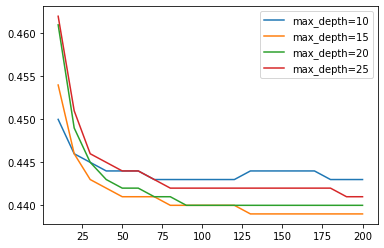

In [76]:
for max_depth in df_errors.max_depth.unique():
    df_subset = df_errors[df_errors.max_depth == max_depth]
    plt.plot( df_subset.n_estimator, df_subset.rmse, label='max_depth={}'.format(max_depth) )
plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [9]:
rfr = perform_random_forest_regressor(X_train,y_train,n_estimators=10,max_depth=20)
importance = pd.DataFrame(list(zip(dv.get_feature_names(),rfr.feature_importances_)),columns=['feature_name','importance'])
importance.sort_values('importance',ascending=False)

,feature_name,importance
12,room_type=Entire home/apt,0.386210
3,longitude,0.157206
2,latitude,0.149997
0,availability_365,0.080481
4,minimum_nights,0.053712
11,reviews_per_month,0.050396
10,number_of_reviews,0.044247
7,neighbourhood_group=Manhattan,0.034413
1,calculated_host_listings_count,0.030849
14,room_type=Shared room,0.004901


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [6]:
features = dv.get_feature_names()
features

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [7]:
dtrain   = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval     = xgb.DMatrix(X_val  , label=y_val  , feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = { 'max_depth':6, 'min_child_weight':1, 'objective':'reg:squarederror', 'nthread':2, 'seed':1, 'verbosity':1 }
xgb_params

In [9]:
def train_xgb(eta):
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

Now change `eta` first to `0.1` and then to `0.01`

In [10]:
%%capture output

for eta in [0.3,0.1,0.01]:
    print('eta:{}'.format(eta))
    train_xgb(eta)

In [28]:
s = output.stdout

'eta:0.3\n[0]\ttrain-rmse:3.02751\tval-rmse:3.02415\n[5]\ttrain-rmse:0.67490\tval-rmse:0.67752\n[10]\ttrain-rmse:0.43912\tval-rmse:0.44981\n[15]\ttrain-rmse:0.42259\tval-rmse:0.43827\n[20]\ttrain-rmse:0.41716\tval-rmse:0.43691\n[25]\ttrain-rmse:0.41365\tval-rmse:0.43621\n[30]\ttrain-rmse:0.40712\tval-rmse:0.43543\n[35]\ttrain-rmse:0.40444\tval-rmse:0.43510\n[40]\ttrain-rmse:0.40103\tval-rmse:0.43466\n[45]\ttrain-rmse:0.39723\tval-rmse:0.43371\n[50]\ttrain-rmse:0.39446\tval-rmse:0.43384\n[55]\ttrain-rmse:0.39129\tval-rmse:0.43378\n[60]\ttrain-rmse:0.38743\tval-rmse:0.43404\n[65]\ttrain-rmse:0.38421\tval-rmse:0.43450\n[70]\ttrain-rmse:0.38117\tval-rmse:0.43467\n[75]\ttrain-rmse:0.37801\tval-rmse:0.43489\n[80]\ttrain-rmse:0.37668\tval-rmse:0.43526\n[85]\ttrain-rmse:0.37259\tval-rmse:0.43537\n[90]\ttrain-rmse:0.36998\tval-rmse:0.43539\n[95]\ttrain-rmse:0.36742\tval-rmse:0.43579\n[99]\ttrain-rmse:0.36478\tval-rmse:0.43621\neta:0.1\n[0]\ttrain-rmse:3.87216\tval-rmse:3.86890\n[5]\ttrain-rmse:

In [44]:
def eta_iterator(s):
    lines = filter(lambda x: len(x),s.split('\n'))
    output_iter = (x[1] for x in groupby(lines, lambda line: line.startswith('eta')))
    for eta_header in output_iter:
        eta = float(eta_header.__next__().strip('eta:'))
        def _extract_line(line):
            it, train_rmse, val_rmse = line.split('\t')
            return { 'eta':eta
                   , 'it':it.strip('[]')
                   , 'train_rmse':float(train_rmse.split(':')[1])
                   , 'val_rmse':float(val_rmse.split(':')[1]) }
        yield( pd.DataFrame([ _extract_line(a) for a in output_iter.__next__()]) )
df_xgb = pd.concat(eta_iterator(s))

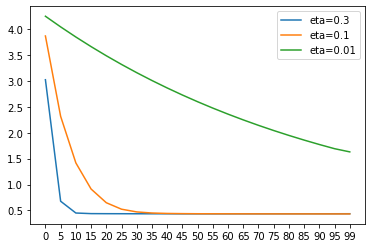

In [46]:
for eta in df_xgb.eta.unique():
    df_subset = df_xgb[df_xgb.eta == eta]
    plt.plot(df_subset.it,df_subset.val_rmse,label='eta={}'.format(eta))
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.



# MacOSX XGBoost install and hang workaround
When you run `pip install xgboost` or when you try to `import xgboost` in a script you might get an warning or error stating that libomp has not been installed and to run `brew install libomp` in the terminal. However this install a version of libomp that does not work with `xgboost`!

This shows in one of two ways after attempting to run `xgb.DMatrix(X_train, label=y_train, feature_names=features)`:

- **python script:** Segmentation fault: 11
- **jupyter notebook:** Never finished running, and notebook is unresponsive until kernal restart. However confusingly I have had it sometimes work

The versions of libomp with this problem are 12.x.x and 13.x.x, however issue has a workaround [xgboost issue #7039](https://github.com/dmlc/xgboost/issues/7039) installing the older libomp 11 using the terminal. In the terminal use: 
```brew list --version libomp```
to determine the current version of libomp if any. Then if you have a problematic version run `brew unlink libomp`.
Now to install the old version of libomp run:
```
brew update
wget https://raw.githubusercontent.com/chenrui333/homebrew-core/0094d1513ce9e2e85e07443b8b5930ad298aad91/Formula/libomp.rb
brew install --build-from-source ./libomp.rb
```
and then run 
```brew list --version libomp```
to check that everything worked, it should now state `libomp 11.1.0`, and your code should now be able to run.